In [311]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import json
import plotly.express as px
from collections import Counter
import random

import io
import requests

import geopandas as gpd
import cartogram

from embed_articles import embed_articles
from cosine_similarity import cosine_sim
from get_data import get_new_articles

## Setting Notebook Parameters

In [312]:
data_filename = 'newsdata.json'
embeddings_filename = 'embedded_articles.pkl'
cossim_desc_filename = 'cosine_similiarties_descriptions.pkl'
cossim_title_filename = 'cosine_similiarties_titles.pkl'
embedding_variables = ['description', 'title']
run_embedding = False   # True if no local file with embeddings
run_cossim = False      # True if no local file with cosine similiarities
save_results = False    # If True, then the embeddings and cossims are saved to a file after they are run
run_new_pos = True     # True if no local file with newest positions

get_new_nodes = False # Set to true if you want to use api credits to get more data

create_new_graph = True # True if you want to create a new graph with your embeddings. False to load in existing from .gml file
save_new_graph = True # True to save your new graph

## Creating Dataset

#### **Get new articles**

In [313]:
# Run to use up to 30 newsdata.io credits for more articles
if get_new_nodes:
    william, bella, nicolai = 'pub_d9de26b5f5c540558489f00542c6366d', 'pub_b17b6c07e5924b47a7266d5a23f43a33', 'pub_2ffc1a6468d240ee80c80400eeea1c23'
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles before: {len(json.load(f))-1}')
    try:
        get_new_articles(api_key=nicolai, data_filename=data_filename, verbose=False)
    except Exception as e:
        print('No more api credits')
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles after: {len(json.load(f))-1}')

#### **Get embeddings and cosine similarities**

In [314]:
if run_embedding:
    # Embedding all articles
    print('Running embedding')
    embedded_articles, embedding_length, num_articles = embed_articles(input_filename=data_filename, 
                                                                    embedding_variables=embedding_variables) 
    print("Size of each embedding:", embedding_length)
    print("Amount of articles reviewed:", num_articles)
    print("Amount of articles embedded:", len(embedded_articles))
    print("Finished running embedding")
    
    if save_results:
        print("Saving embeddings to file")
        with open(embeddings_filename, 'wb') as f:
            pickle.dump(embedded_articles, f)
else:
    with open(embeddings_filename, 'rb') as f:
        embedded_articles = pickle.load(f)

if run_cossim:
    # Calculating cosine similarity on titles and descriptions
    print()
    print("Running cosine similarity")
    emb_titles = []
    emb_desc = []
    for key in embedded_articles.keys():
        emb_titles.append(embedded_articles[key]['embedded_title'])
        emb_desc.append(embedded_articles[key]['embedded_description'])
    print("Running cosine similarities for titles")
    cossim_titles = cosine_sim(input_data=emb_titles)
    print("Running cosine similarities for descriptions")
    cossim_desc = cosine_sim(input_data=emb_desc)
        
    print("Finished running cosine similarity")
    
    if save_results:
        print("Saving cossims to file")
        with open(cossim_title_filename, 'wb') as f:
            pickle.dump(cossim_titles, f)
        with open(cossim_desc_filename, 'wb') as f:
            pickle.dump(cossim_desc, f)
else:
    with open(cossim_desc_filename, 'rb') as f:
        cossim_desc = pickle.load(f)
    with open(cossim_title_filename, 'rb') as f:
        cossim_titles = pickle.load(f)

## Extracting attributes for creating graph

In [315]:
# Getting articles without embeddings for creating attributes for nx graph
print('Extracting articles without embeddings')
all_articles = {}
for id, article in embedded_articles.items():
    article_no_embedding = article
    for var in embedding_variables:
        article_no_embedding.pop(f'embedded_{var}')
    all_articles[id] = article_no_embedding

Extracting articles without embeddings


In [316]:
## Turning graph into dataframe 
# Turning articles id's into node attributes
# Turning country from list to string
nwdf_init = pd.DataFrame.from_dict(all_articles, orient='index')
nwdf_init.index.name = 'article id'
nwdf_init = nwdf_init.reset_index()
nwdf_init['country'] = nwdf_init['country'].str[0]

## Adding press freedom index data

pressfreedom = pd.read_csv('RWB_PFI_WIDEF.csv') 

# Removing non-informative attributes
non_informative_att = []
for attribute in pressfreedom.keys():
    if len(pressfreedom[attribute].unique()) < 2:
        non_informative_att.append(attribute)
pressfreedom = pressfreedom.drop(columns=non_informative_att, axis=1)
pressfreedom = pressfreedom.drop(columns=['REF_AREA', 'UNIT_TYPE', 'INDICATOR', 'UNIT_MEASURE', 'UNIT_TYPE_LABEL', 'UNIT_MEASURE_LABEL'], axis=1)

# Cleaning country names and indicator labels
names = {'Viet Nam': 'Vietnam', 'Venezuela, RB': 'Venezuela', 'Russian Federation': 'Russia', 
         'Kyrgyz Republic': 'Kyrgyzstan', 'Hong Kong SAR, China': 'Hong Kong', 
         'United States': 'United States of America', 'Syrian Arab Republic': 'Syria', 
         'Iran, Islamic Rep.': 'Iran', 'Netherlands': 'Netherland', 'Korea, Rep.': 'South Korea'}

labels = {'sociocultural context': 'sociocultural context score',
 'safety': 'safety score',
 'legal framework': 'legal framework score',
 'political context': 'political context score',
 'economic context': 'economic context score'}

pressfreedom['REF_AREA_LABEL'] = (pressfreedom['REF_AREA_LABEL'].replace(names)) # Correcting country names
pressfreedom['REF_AREA_LABEL'] = pressfreedom['REF_AREA_LABEL'].str.lower() # Lowercase country names
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.lower() # Lowercase indicator labels
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.removeprefix('press freedom index: ') # Removing prefix
pressfreedom['INDICATOR_LABEL'] = (pressfreedom['INDICATOR_LABEL'].replace(labels)) # Renaming some indicators to include that they are scores

# Getting list of countries in the network
countries = []
for article_id, article_attrs in all_articles.items():
    if article_attrs['country'][0] not in countries:
        countries.append(article_attrs['country'][0])
countries = set(countries)

# Removing non-countries
countries.remove('world')
countries.remove('solomon islands')

# Attaching press freedom data to countries in the network
x = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
indicators = list(pressfreedom['INDICATOR_LABEL'].unique())
indicators.remove('press freedom index rank')

country_data_pf = {}
for country in countries:
    if country in pressfreedom['REF_AREA_LABEL'].values: # Only include countries with press freedom data
        # Getting press freedom ranks over time for country
        mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
        (pressfreedom['INDICATOR_LABEL'] == 'press freedom index rank'))
        out = pressfreedom.loc[mask, '2002':'2025'].values[0]
        new_out = []
        new_x = []
        for i in range(len(out)):
            if out[i] == 'nan' or np.isnan(out[i]):
                continue
            else:
                new_out.append(out[i])
                new_x.append(x[i])
        # Get statistics of press freedom ranks
        mean, minrank, maxrank, median, variance, slope = round(np.mean(new_out),2), np.min(new_out), np.max(new_out), np.median(new_out), round(np.var(new_out),2), stats.linregress(new_x,list(new_out))[0]
        country_data_pf[country] = {'press freedom current rank': new_out[-1], 
                                                            'press freedom slope of ranks': slope, 'press freedom mean rank': mean, 
                                                            'press freedom median rank': median, 'press freedom variance': variance, 
                                                            'press freedom min rank': minrank, 'press freedom max rank': maxrank}
        # Getting other indicators for the country for 2025
        for indicator in indicators:
            mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
            (pressfreedom['INDICATOR_LABEL'] == indicator))
            out = pressfreedom.loc[mask, '2025'].values[0]
            country_data_pf[country][indicator] = out  
# Creating dataframe
pressfreedompd = pd.DataFrame.from_dict(country_data_pf, orient='index').reset_index().rename(columns={'index': 'country'})

## Adding corruption perception index data
# 'Entity' is the country name column
# 'World regions according to OWID' is the continent column
corruption = pd.read_csv('ti-corruption-perception-index.csv')
corruption['Entity'] = corruption['Entity'].str.lower()
corruption['World regions according to OWID'] = corruption['World regions according to OWID'].str.lower()

# Cleaning country names
names = {'united states': 'united states of america', 'netherlands': 'netherland'}
corruption['Entity'] = (corruption['Entity'].replace(names))

# Creating dictionary of continents and their countries
conts_dict = {cont: [] for cont in corruption['World regions according to OWID'].unique()[1:]} # Skipping first value which is NaN
for cont in corruption['World regions according to OWID'].unique()[1:]: 
        mask = ((corruption['World regions according to OWID'] == cont))
        out = corruption.loc[mask, 'Entity'].values
        conts_dict[cont] = out

# Getting list of corruption countries that are also in our dataset
cor_countries = []
for country in list(corruption['Entity'].unique()):
    if country in countries:
        cor_countries.append(country)
cor_countries = set(cor_countries)

corruption_dict = {country: {} for country in countries}
for country in countries:
    if country in corruption['Entity'].values: # Only include countries with corruption data
        years = corruption.loc[((corruption['Entity'] == country)), 'Year'].values
        x = []
        y = []
        for year in years:
            # Getting corruption scores over time for country
            mask = ((corruption['Entity'] == country) &
                    (corruption['Year'] == year))
            if np.isnan(corruption.loc[mask, 'Corruption Perceptions Index'].values[0]):
                print(f"{country} has nan-value in {year}. Did not include")
            else:
                x.append(year)
                y.append(corruption.loc[mask, 'Corruption Perceptions Index'].values[0])
        if len(y) > 0:
            mean, minrank, maxrank, median, variance = round(np.mean(y),2), np.min(y), np.max(y), np.median(y), round(np.var(y),2)
            if len(y) >= 2:
                slope = stats.linregress(x, y).slope
            else:
                slope = 0
            corruption_dict[country] = {'corruption latest score': y[-1], 'corruption score slope': slope, 'corruption mean score': mean, 'corruption median score': median, 'corruption score variance': variance, 'corruption min score': minrank, 'corruption max score': maxrank}
    for cont in conts_dict:
        if country in conts_dict[cont]:
            corruption_dict[country]['continent'] = cont
# Adding corruption data to dataframe
corruptpd = pd.DataFrame.from_dict(corruption_dict, orient='index').reset_index().rename(columns={'index': 'country'})

# Adding both as attributes in the network
nwdf_pf = pd.merge(nwdf_init,pressfreedompd, on="country", how="left")
nwdf_pf_co = pd.merge(nwdf_pf,corruptpd, on="country", how="left")

# Cleaning netherland name in nwdf
for country in nwdf_pf_co['country']: 
    if country == 'netherland':
        nwdf_pf_co.loc[nwdf_pf_co['country'] == country, 'country'] = 'netherlands'

belize has nan-value in 2023. Did not include


#### **Creating df of countries with some relevant data of theirs**

In [317]:
country_counts = Counter([all_articles[article_id]["country"][0] for article_id in all_articles.keys()])
country_counts_pd = pd.DataFrame(list(country_counts.items()), columns=["country", "count"])

coruption_data = {country: corruption_dict[country] for country in corruption_dict if len(list(corruption_dict[country])) > 1}
combined_data = {}
for country in country_data_pf.keys():
    combined_data[country] = {
        'press freedom current rank': country_data_pf[country]['press freedom current rank'],
        'press freedom slope of ranks': round(country_data_pf[country]['press freedom slope of ranks'], 2),
        'corruption latest score': coruption_data[country]['corruption latest score'] if country in coruption_data else None,
        'corruption score slope': round(coruption_data[country]['corruption score slope'], 2) if country in coruption_data else None
    }
combined_data_df = pd.DataFrame.from_dict(combined_data, orient='index').reset_index().rename(columns={'index': 'country'})
df = pd.merge(country_counts_pd,combined_data_df[["country", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country", how="left")
df.head()

country  count  press freedom current rank  \
0                 australia    371                        29.0   
1            united kingdom    378                        20.0   
2  united states of america   2622                        57.0   
3                    canada    392                        21.0   
4               south korea     21                        61.0   

   press freedom slope of ranks  corruption latest score  \
0                         -0.09                     77.0   
1                          0.24                     71.0   
2                          1.41                     65.0   
3                          0.14                     75.0   
4                          0.49                     64.0   

   corruption score slope  
0                   -0.66  
1                   -0.47  
2                   -0.74  
3                   -0.82  
4                    0.91

#### **Adding more data to df and nwdf using naturalearth database**

The DataFrame **world** below here is downloaded from natural earths geo data sets in size $1:110m$ and has a lot of information. The following are the ones i found interesting. All information is descriped in world_data_set_description.ipynb

- **ADMIN**
- - Administrative name of the country in "short-form english"
- **POP_EST**
- - Estimated population
- **POP_YEAR**
- - Year the estimated population is taken
- **GDP_MD**
- - Gross Domestic Product in millions of dollars (MD)
- **GDP_YEAR**
- - Year the Gross Domestic Product is taken.
- **ECONOMY**
- - E.g. *'1. Developed region: G7'*, *'7. Least developed region'* etc.
- **INCOME_GRP**
- - One of these groups: *'1. High income: OECD', '2. High income: nonOECD', '3. Upper middle income', '4. Lower middle income', '5. Low income'*
- **WIKIDATAID**
- - Wikidata-ID (e.g. Q191 for Estland, Q954 for Zimbabwe). Could be used if information from wiki is wanted.
- **SOVEREIGNT**
- - Sovereign entity. E.g. for *'Greenland'* it is *'Denmark'*
- **SUBUNIT**
- - E.g. *'Scotland'* as subunit of *'United Kingdom'*
- **TYPE**
- - E.g. *'Sovereign country'*, *'Disputed'*, *'Dependency'* etc.
- **BRK_NAME**
- - What the breakaway entity calls it self
- **NOTE_BRK**
- - Notes about breakaway status. E.g. *'Self admin.; Claimed by China'*
- **FCLASS_xx**
- - xx is a big entity. Whether the entity recognizes the country. e.g. *'Admin-0 breakaway and disputed', 'Unrecognized', 'Admin-0 country'* 
- **CONTINENT**
- - The continent where the country is place
- **SUBREGION**
- - E.g. *Northern Europe, Eastern Africa*
- **geometry**
- - The geometry of the country. Either in Multipolygon or Polygon.

In [318]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

world = world.rename(columns={"ADMIN": "country"})
world = world[world["country"] != "Antarctica"]
world = world.to_crs("EPSG:4087")
world["country_norm"] = world["country"].str.lower().str.strip()

df_fixed = df.copy()
df_fixed["country"] = df_fixed["country"].str.strip().str.lower()

name_fix = {
    "netherland": "netherlands",
}
df_fixed["country"] = df_fixed["country"].replace(name_fix)
df_fixed["country_norm"] = df_fixed["country"]

gdf = world.merge(df_fixed[["country_norm", "count", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country_norm", how="inner")
gdf["articles_per_million"] = round((gdf["count"] / gdf["POP_EST"]) * 10e6 , 2)
keep = ['country_norm', 'POP_EST', 'GDP_MD', 'INCOME_GRP', 'count', 'articles_per_million', 'geometry', "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']
gdf = gdf[keep]
gdf.rename(columns={"country_norm": "country", "POP_EST": "population", 'GDP_MD': "gross domestic product (millions usd)", "INCOME_GRP": "income group", "count": "number of articles", "articles_per_million": "articles per million capita"}, inplace=True)
nwdf_ne = pd.merge(nwdf_pf_co,gdf[['country', 'population', 'gross domestic product (millions usd)', 'income group', 'number of articles', 'articles per million capita']], on='country', how='left')

#### **Links to more data**

In [319]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"
}

# https://ourworldindata.org/grapher/gdp-per-capita-worldbank
url_gdp_capita = "https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?v=1&csvType=full&useColumnShortNames=true"

# https://ourworldindata.org/grapher/inflation-of-consumer-prices?overlay=download-data
url_inflation = "https://ourworldindata.org/grapher/inflation-of-consumer-prices.csv?v=1&csvType=full&useColumnShortNames=true" 

# https://ourworldindata.org/grapher/consumer-price-index
url_consumer_price_index = "https://ourworldindata.org/grapher/consumer-price-index.csv?v=1&csvType=full&useColumnShortNames=true"


# https://ourworldindata.org/grapher/median-age?overlay=download-data
url_median_age = "https://ourworldindata.org/grapher/median-age.csv?v=1&csvType=full&useColumnShortNames=true"

#https://ourworldindata.org/grapher/average-years-of-schooling?overlay=download-data
url_average_schooling_years = "https://ourworldindata.org/grapher/average-years-of-schooling.csv?v=1&csvType=full&useColumnShortNames=true"

#### **Geting more data about countries using above links from 'ourworldindata'**

In [320]:
r = requests.get(url_gdp_capita, headers=headers)
r.raise_for_status()
gdp_capita = pd.read_csv(io.StringIO(r.text))
gdp_capita = gdp_capita[(gdp_capita.Year == 2024)][['Entity', 'ny_gdp_pcap_pp_kd']]
gdp_capita.rename(columns={'Entity': 'country', 'ny_gdp_pcap_pp_kd': 'gdp per capita 2024 international dollars'}, inplace=True)
gdp_capita['country'] = gdp_capita['country'].str.lower()

r = requests.get(url_inflation, headers=headers)
r.raise_for_status()
inflation = pd.read_csv(io.StringIO(r.text))
inflation = inflation[inflation.Year == 2024][['Entity', 'fp_cpi_totl_zg']]
inflation.rename(columns={'Entity': 'country', 'fp_cpi_totl_zg': 'inflation 2024 percent change'}, inplace=True)
inflation['country'] = inflation['country'].str.lower()

r = requests.get(url_consumer_price_index, headers=headers)
r.raise_for_status()
consumer_price_index = pd.read_csv(io.StringIO(r.text))
consumer_price_index = consumer_price_index[consumer_price_index.Year == 2024]
consumer_price_index.rename(columns={'Entity': 'country', 'fp_cpi_totl': 'consumer price index in 2024 compared to 2010'}, inplace=True)
consumer_price_index['country'] = consumer_price_index['country'].str.lower()
consumer_price_index = consumer_price_index[['country', 'consumer price index in 2024 compared to 2010']]

r = requests.get(url_median_age, headers=headers)
r.raise_for_status()
median_age = pd.read_csv(io.StringIO(r.text))
median_age = median_age[median_age.Year == 2024]
median_age = median_age[['Entity', 'median_age__sex_all__age_all__variant_medium']]
median_age.rename(columns={'Entity': 'country', 'median_age__sex_all__age_all__variant_medium': 'median age 2024'}, inplace=True)
median_age['country'] = median_age['country'].str.lower()

r = requests.get(url_average_schooling_years, headers=headers)
r.raise_for_status()
school_years = pd.read_csv(io.StringIO(r.text))
school_years = school_years[school_years.Year == 2023]
school_years.rename(columns={'Entity': 'country', 'mys__sex_total': 'average years of schooling 2023'}, inplace=True)
school_years['country'] = school_years['country'].str.lower()
school_years = school_years[['country', 'average years of schooling 2023']]

nwdf_owid = pd.merge(nwdf_ne,gdp_capita, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,inflation, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,consumer_price_index, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,median_age, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,school_years, on='country', how='left')

#### **## Adding sentiment score to dataframe**

Virker ikke uden json filerne

In [321]:
# with open('sentiments_description.json', 'r') as f:
#     sentiments_description = json.load(f)
# with open('sentiments_title.json', 'r') as f:
#     sentiments_title = json.load(f)
# sentimentd = pd.DataFrame.from_dict(sentiments_description, orient='index')
# sentimentt = pd.DataFrame.from_dict(sentiments_title, orient='index')
# sentimentd.index.name = 'article id'
# sentimentt.index.name = 'article id'
# sentimentd.rename(columns={0: 'description sentiment score'}, inplace=True)
# sentimentt.rename(columns={0: 'title sentiment score'}, inplace=True)
# sentimentpd = pd.merge(sentimentd, sentimentt, on='article id', how='left')
# sentimentpd.reset_index(inplace=True)
# nwdf = pd.merge(nwdf_owid,sentimentpd, on='article id', how='left')

#### **Final dataset**

In [322]:
nwdf = nwdf_owid

## Make index of nwdf the article id again
nwdf = nwdf.set_index('article id')
nwdf.rename(columns={
    'pubDate': 'publication_date'
}, inplace=True)
# Renaming columns to have underscores instead of spaces, as spaces in attribute names won't work for .gml files later
nwdf.rename(columns={
    key: key.replace(' ', '_').replace('(', '').replace(')', '') for key in nwdf.columns
}, inplace=True)

## Plotting the dataset

#### **Barplot of the amount of articles per country**

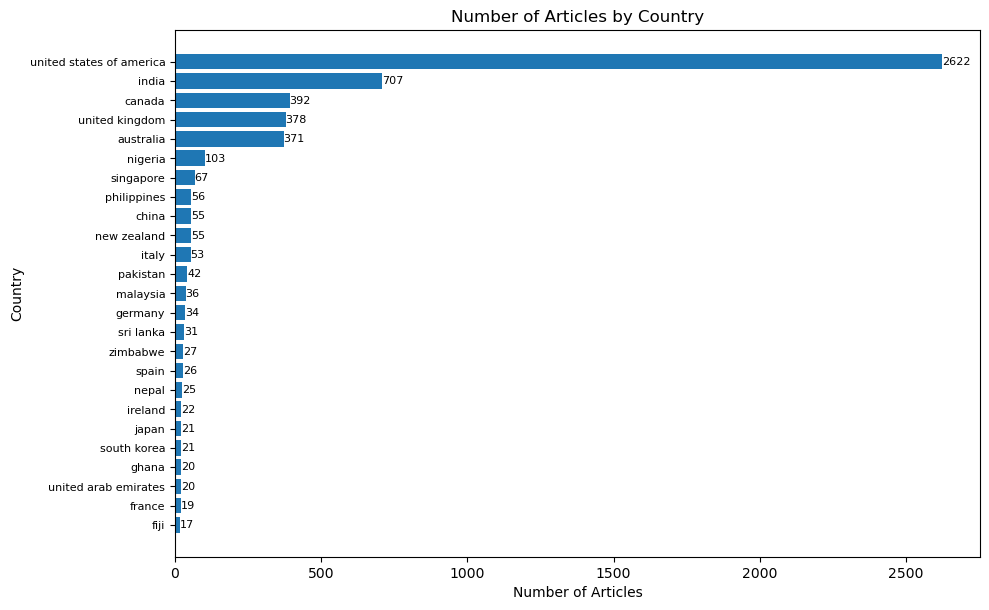

In [323]:
x = []
y = []
for country in sorted(country_counts.items(), key=lambda item: item[1], reverse=False):
    x.append(country[0])
    y.append(country[1])

amount_of_countries = 25
plt.figure(figsize=(10, 6))
plt.barh(x[-amount_of_countries:],y[-amount_of_countries:])
plt.ylabel('Country')
plt.xlabel('Number of Articles')
for _,  out in enumerate(sorted(country_counts.items(), key=lambda item: item[1], reverse=False)[-amount_of_countries:]):
    j = out[0]
    val = out[1]
    plt.text(val, j,
            f"{val:.0f}", va='center',
            ha='left' if val >= 0 else 'right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.title('Number of Articles by Country')
plt.show()

#### **Choropleth map of the world from number of articles per country.**

In [324]:
fig = px.choropleth(
    df,
    locations="country",          # Column with country names
    locationmode="country names", # Let Plotly match names automatically
    color="count",                # Color scale based on article count
    color_continuous_scale="Viridis",
    title="Number of Articles per Country",
)

fig.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_39860\3806502643.py:1: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



#### **Creating cartograms of the world**

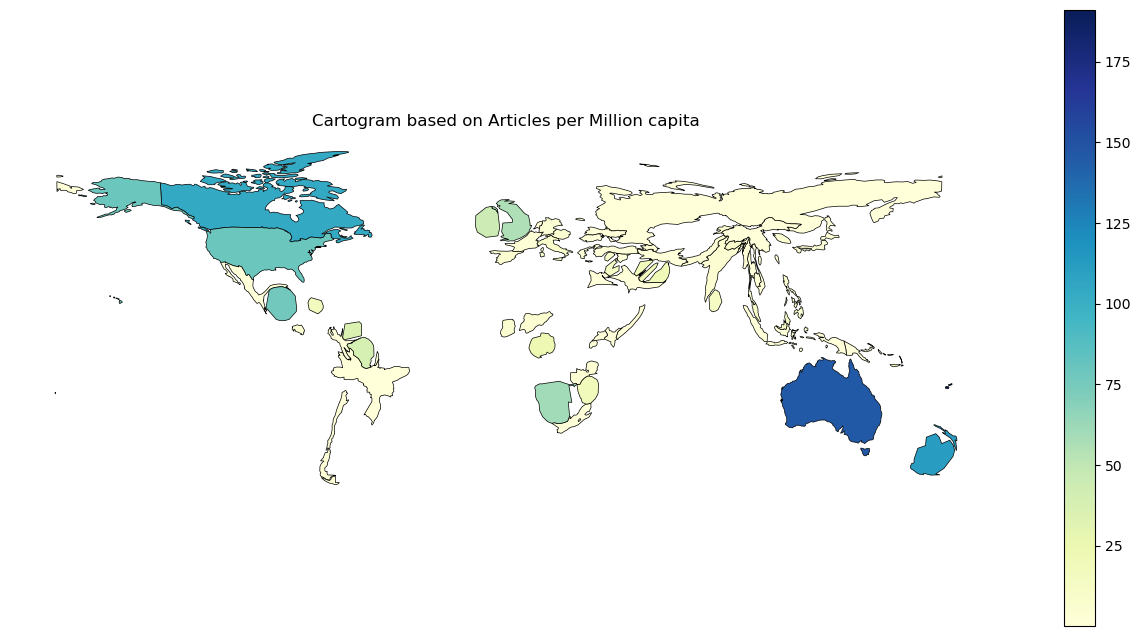

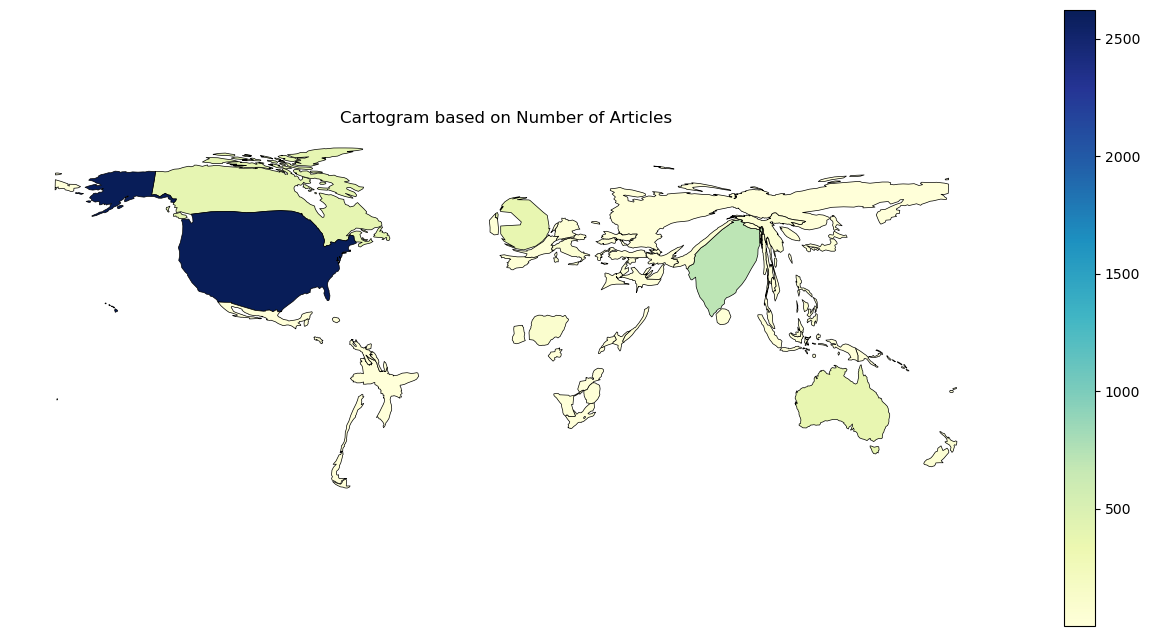

In [325]:
c = cartogram.Cartogram(
    gdf,
    "articles per million capita",
    max_iterations=30,  
    max_average_error=0.1 
)
ax = c.plot(
    column="articles per million capita",
    legend=True,
    figsize=(16, 8),
    edgecolor="black",
    linewidth=0.5,
    cmap="YlGnBu",
)
ax.set_axis_off()
ax.set_title("Cartogram based on Articles per Million capita")
plt.show()

c = cartogram.Cartogram(
    gdf,
    "number of articles",
    max_iterations=10,  
    max_average_error=0.1 
)
ax = c.plot(
    column="number of articles",
    legend=True,
    figsize=(16, 8),
    edgecolor="black",
    linewidth=0.5,
    cmap="YlGnBu",
)
ax.set_axis_off()
ax.set_title("Cartogram based on Number of Articles")
plt.show()

#### **Interactive choropleth map based on articles per million capita**

In [326]:
gdf.explore(column="articles per million capita", legend=True)

## Creating Graph

In [327]:
thres = 0.35
if create_new_graph:
    attr_dict = nwdf.to_dict(orient='index')
    
    G = nx.Graph()
    G.add_nodes_from(list(all_articles.keys()))

    for i in tqdm(range(len(cossim_desc)-1)):
        id_i = list(all_articles.keys())[i]
        for j in range(i+1, len(cossim_desc)):
            id_j = list(all_articles.keys())[j]
            if cossim_desc[i][j] >= thres:
                G.add_edge(id_i, id_j)

    nx.set_node_attributes(G, attr_dict)
    
    if save_new_graph:
        nx.write_gml(G, f'nx_graph_{thres}.gml')
else:
    G = nx.read_gml(f'nx_graph_{thres}.gml')

100%|██████████| 5400/5400 [10:22<00:00,  8.68it/s] 


In [330]:
H = G.subgraph(max(nx.connected_components(G), key=len))
print("Number of nodes in largest connected component:", H.number_of_nodes())
print("Number of edges in largest connected component:", H.number_of_edges())
print("Node attributes are:", list(list(H.nodes(data=True))[0][1].keys()))
print(f"{round(len(H.nodes())/len(G.nodes())*100,2)}% of the nodes are in the largest connected component.")

Number of nodes in largest connected component: 5211
Number of edges in largest connected component: 71167
Node attributes are: ['link', 'title', 'description', 'country', 'category', 'publication_date', 'source_id', 'source_name', 'press_freedom_current_rank', 'press_freedom_slope_of_ranks', 'press_freedom_mean_rank', 'press_freedom_median_rank', 'press_freedom_variance', 'press_freedom_min_rank', 'press_freedom_max_rank', 'sociocultural_context_score', 'legal_framework_rank', 'legal_framework_score', 'sociocultural_context_rank', 'safety_score', 'economic_context_score', 'safety_rank', 'political_context_rank', 'press_freedom_index_score', 'political_context_score', 'economic_context_rank', 'corruption_latest_score', 'corruption_score_slope', 'corruption_mean_score', 'corruption_median_score', 'corruption_score_variance', 'corruption_min_score', 'corruption_max_score', 'continent', 'population', 'gross_domestic_product_millions_usd', 'income_group', 'number_of_articles', 'articles_pe

#### **Calculating Friendship Paradox for 1000 random nodes**

In [332]:
random.seed(42)
random_nodes = random.choices(list(H.nodes()), k=1000)

true_paradox_count = 0
for i in tqdm(random_nodes):
    neighbors = list(H.neighbors(i))
    neighbor_degrees = [H.degree(neighbor) for neighbor in neighbors]
    average_neighbor_degree = np.mean(neighbor_degrees)
    if average_neighbor_degree > H.degree(i):
        true_paradox_count += 1
print("Out of 1000 random nodes, the friendship paradox is true for", true_paradox_count, "nodes.")

100%|██████████| 1000/1000 [00:05<00:00, 192.78it/s]

Out of 1000 random nodes, the friendship paradox is true for 803 nodes.


## Plotting the Graph

In [333]:
## Calculating forceatlas2 positions for plotting
if run_new_pos:
    pos = nx.forceatlas2_layout(G, max_iter=100, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    pos2 = nx.forceatlas2_layout(H, max_iter=100, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    with open(f'POS_{thres}.pkl', 'wb') as f:    # Saving POS as for later use, as they take time to compute
        pickle.dump(pos, f)
    with open(f'POS2_{thres}.pkl', 'wb') as f:
        pickle.dump(pos2, f)
else:
    with open(f'POS_{thres}.pkl', 'rb') as f:    # Loading previously computed POS
        pos = pickle.load(f)
    with open(f'POS2_{thres}.pkl', 'rb') as f:
        pos2 = pickle.load(f)

c:\Users\willi\anaconda3\envs\SGI\Lib\site-packages\networkx\drawing\layout.py:1809: RuntimeWarning:

invalid value encountered in divide



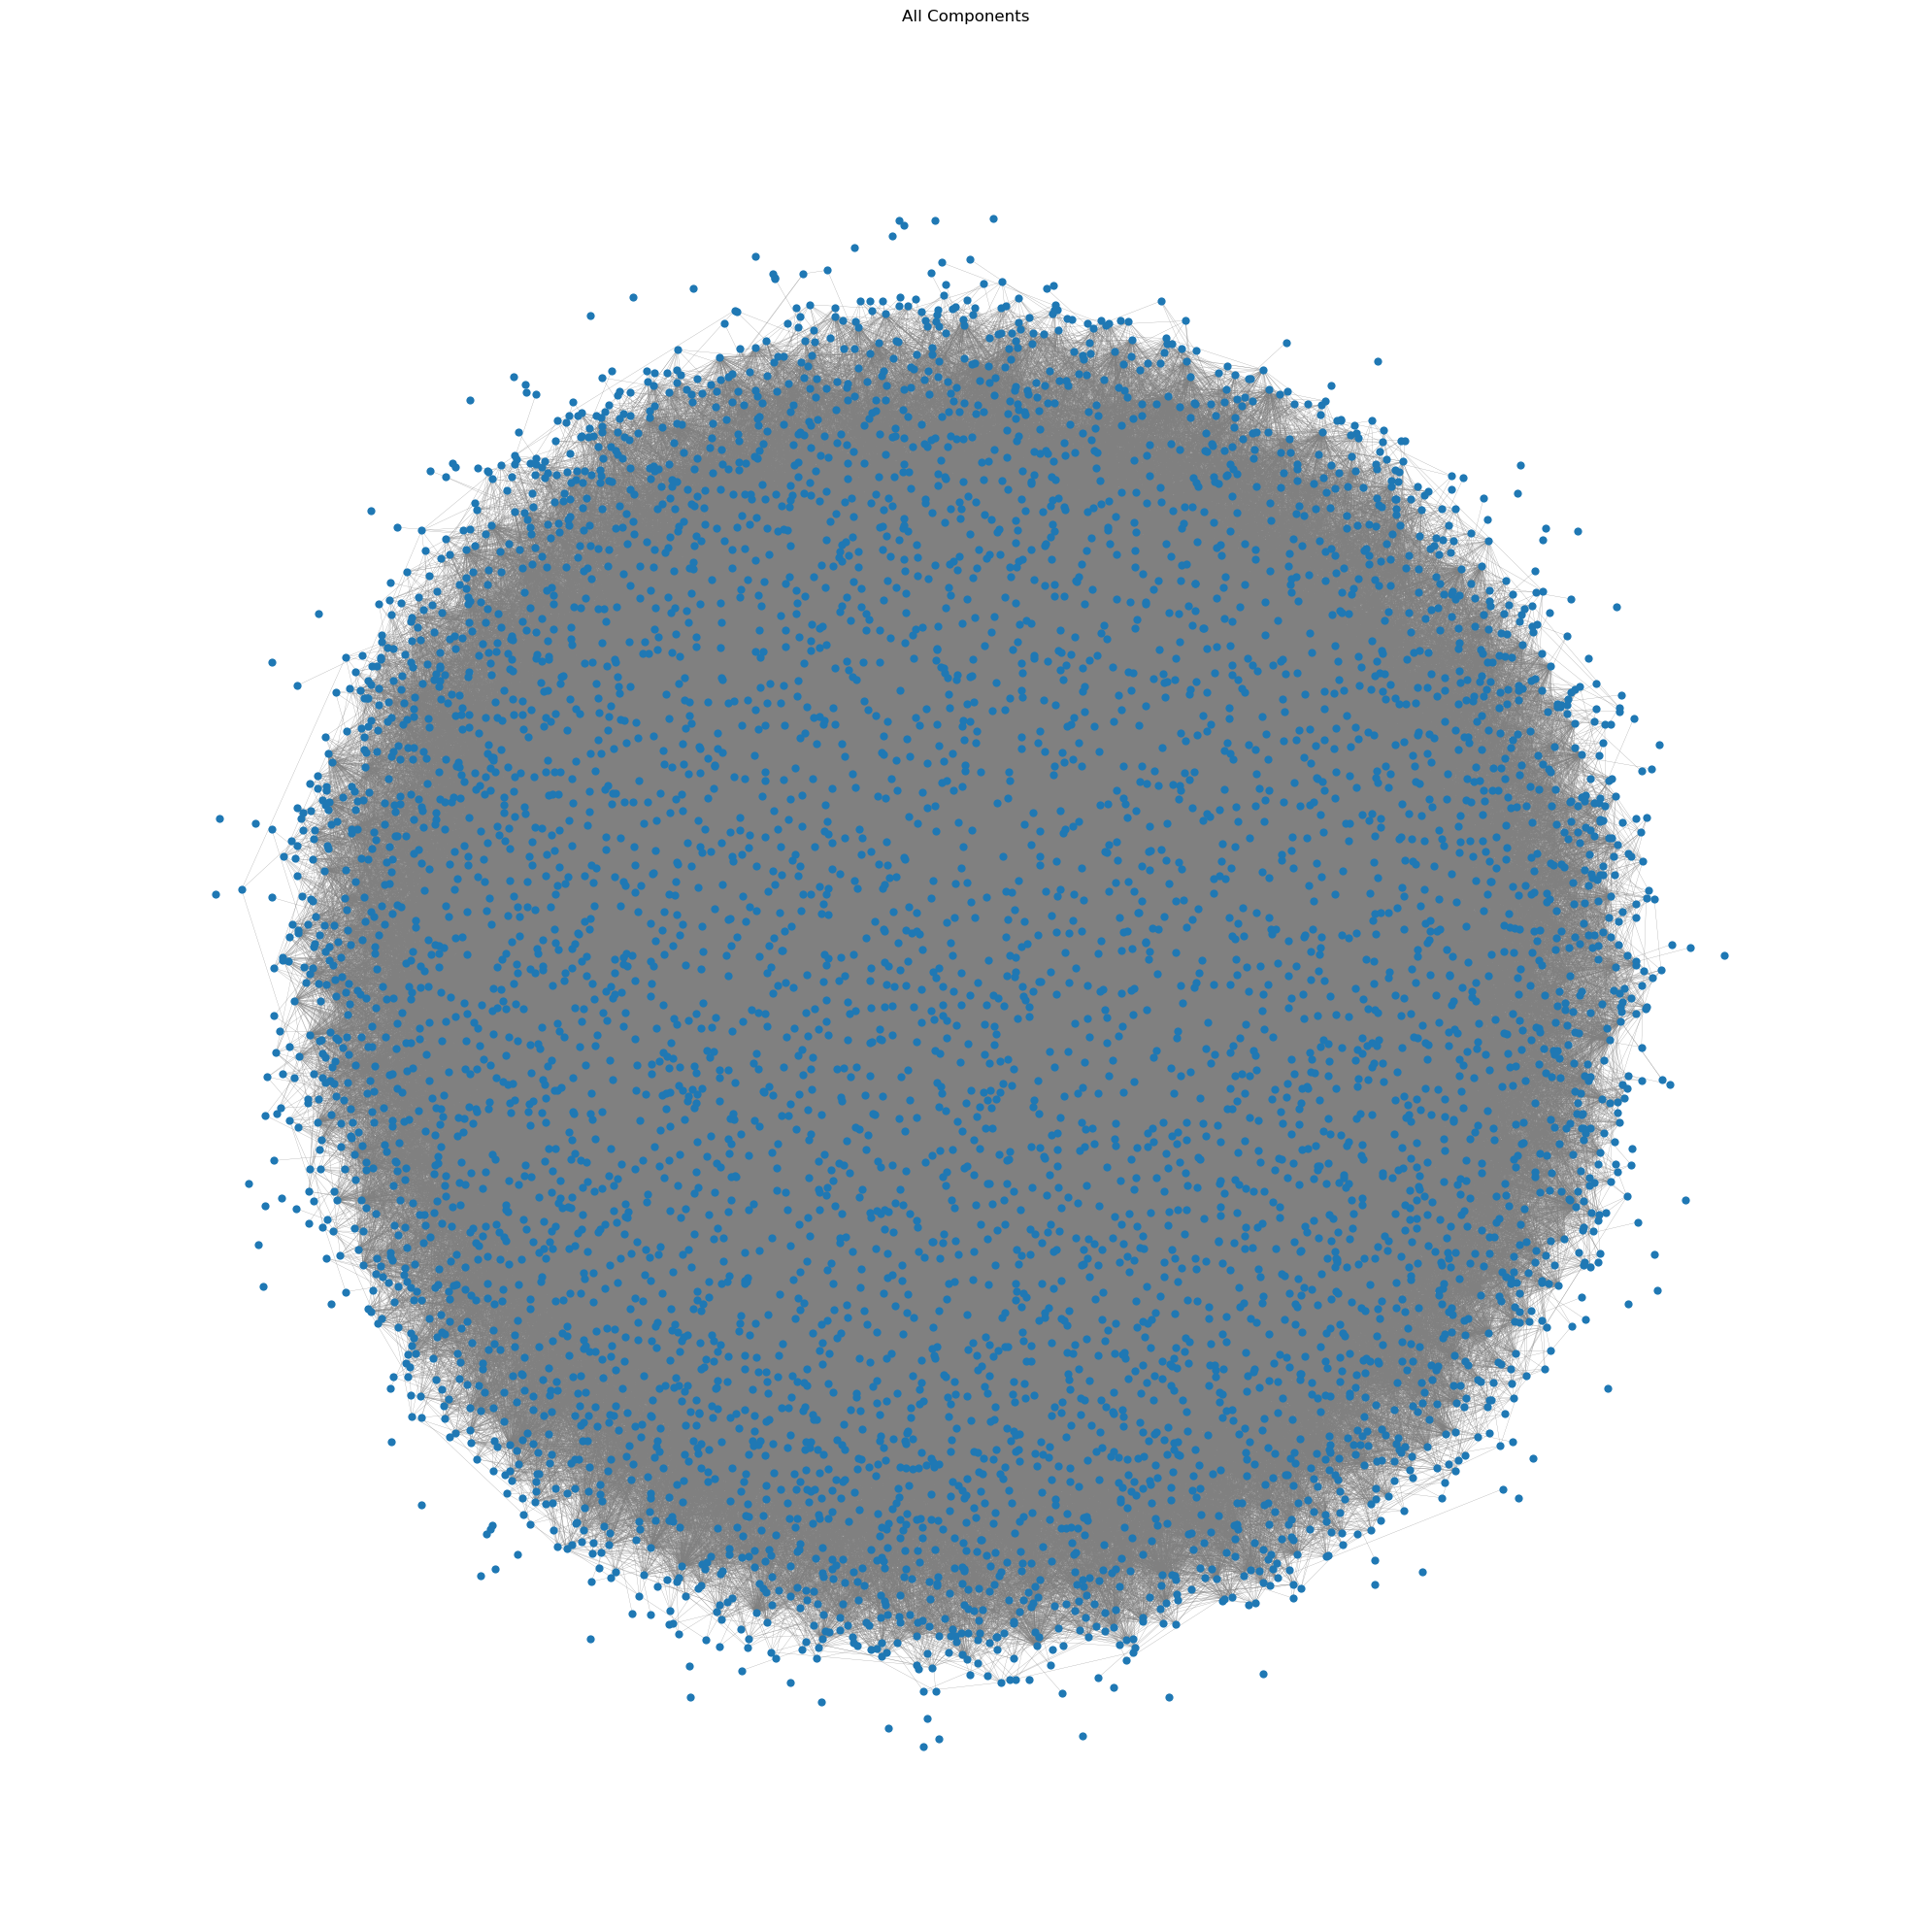

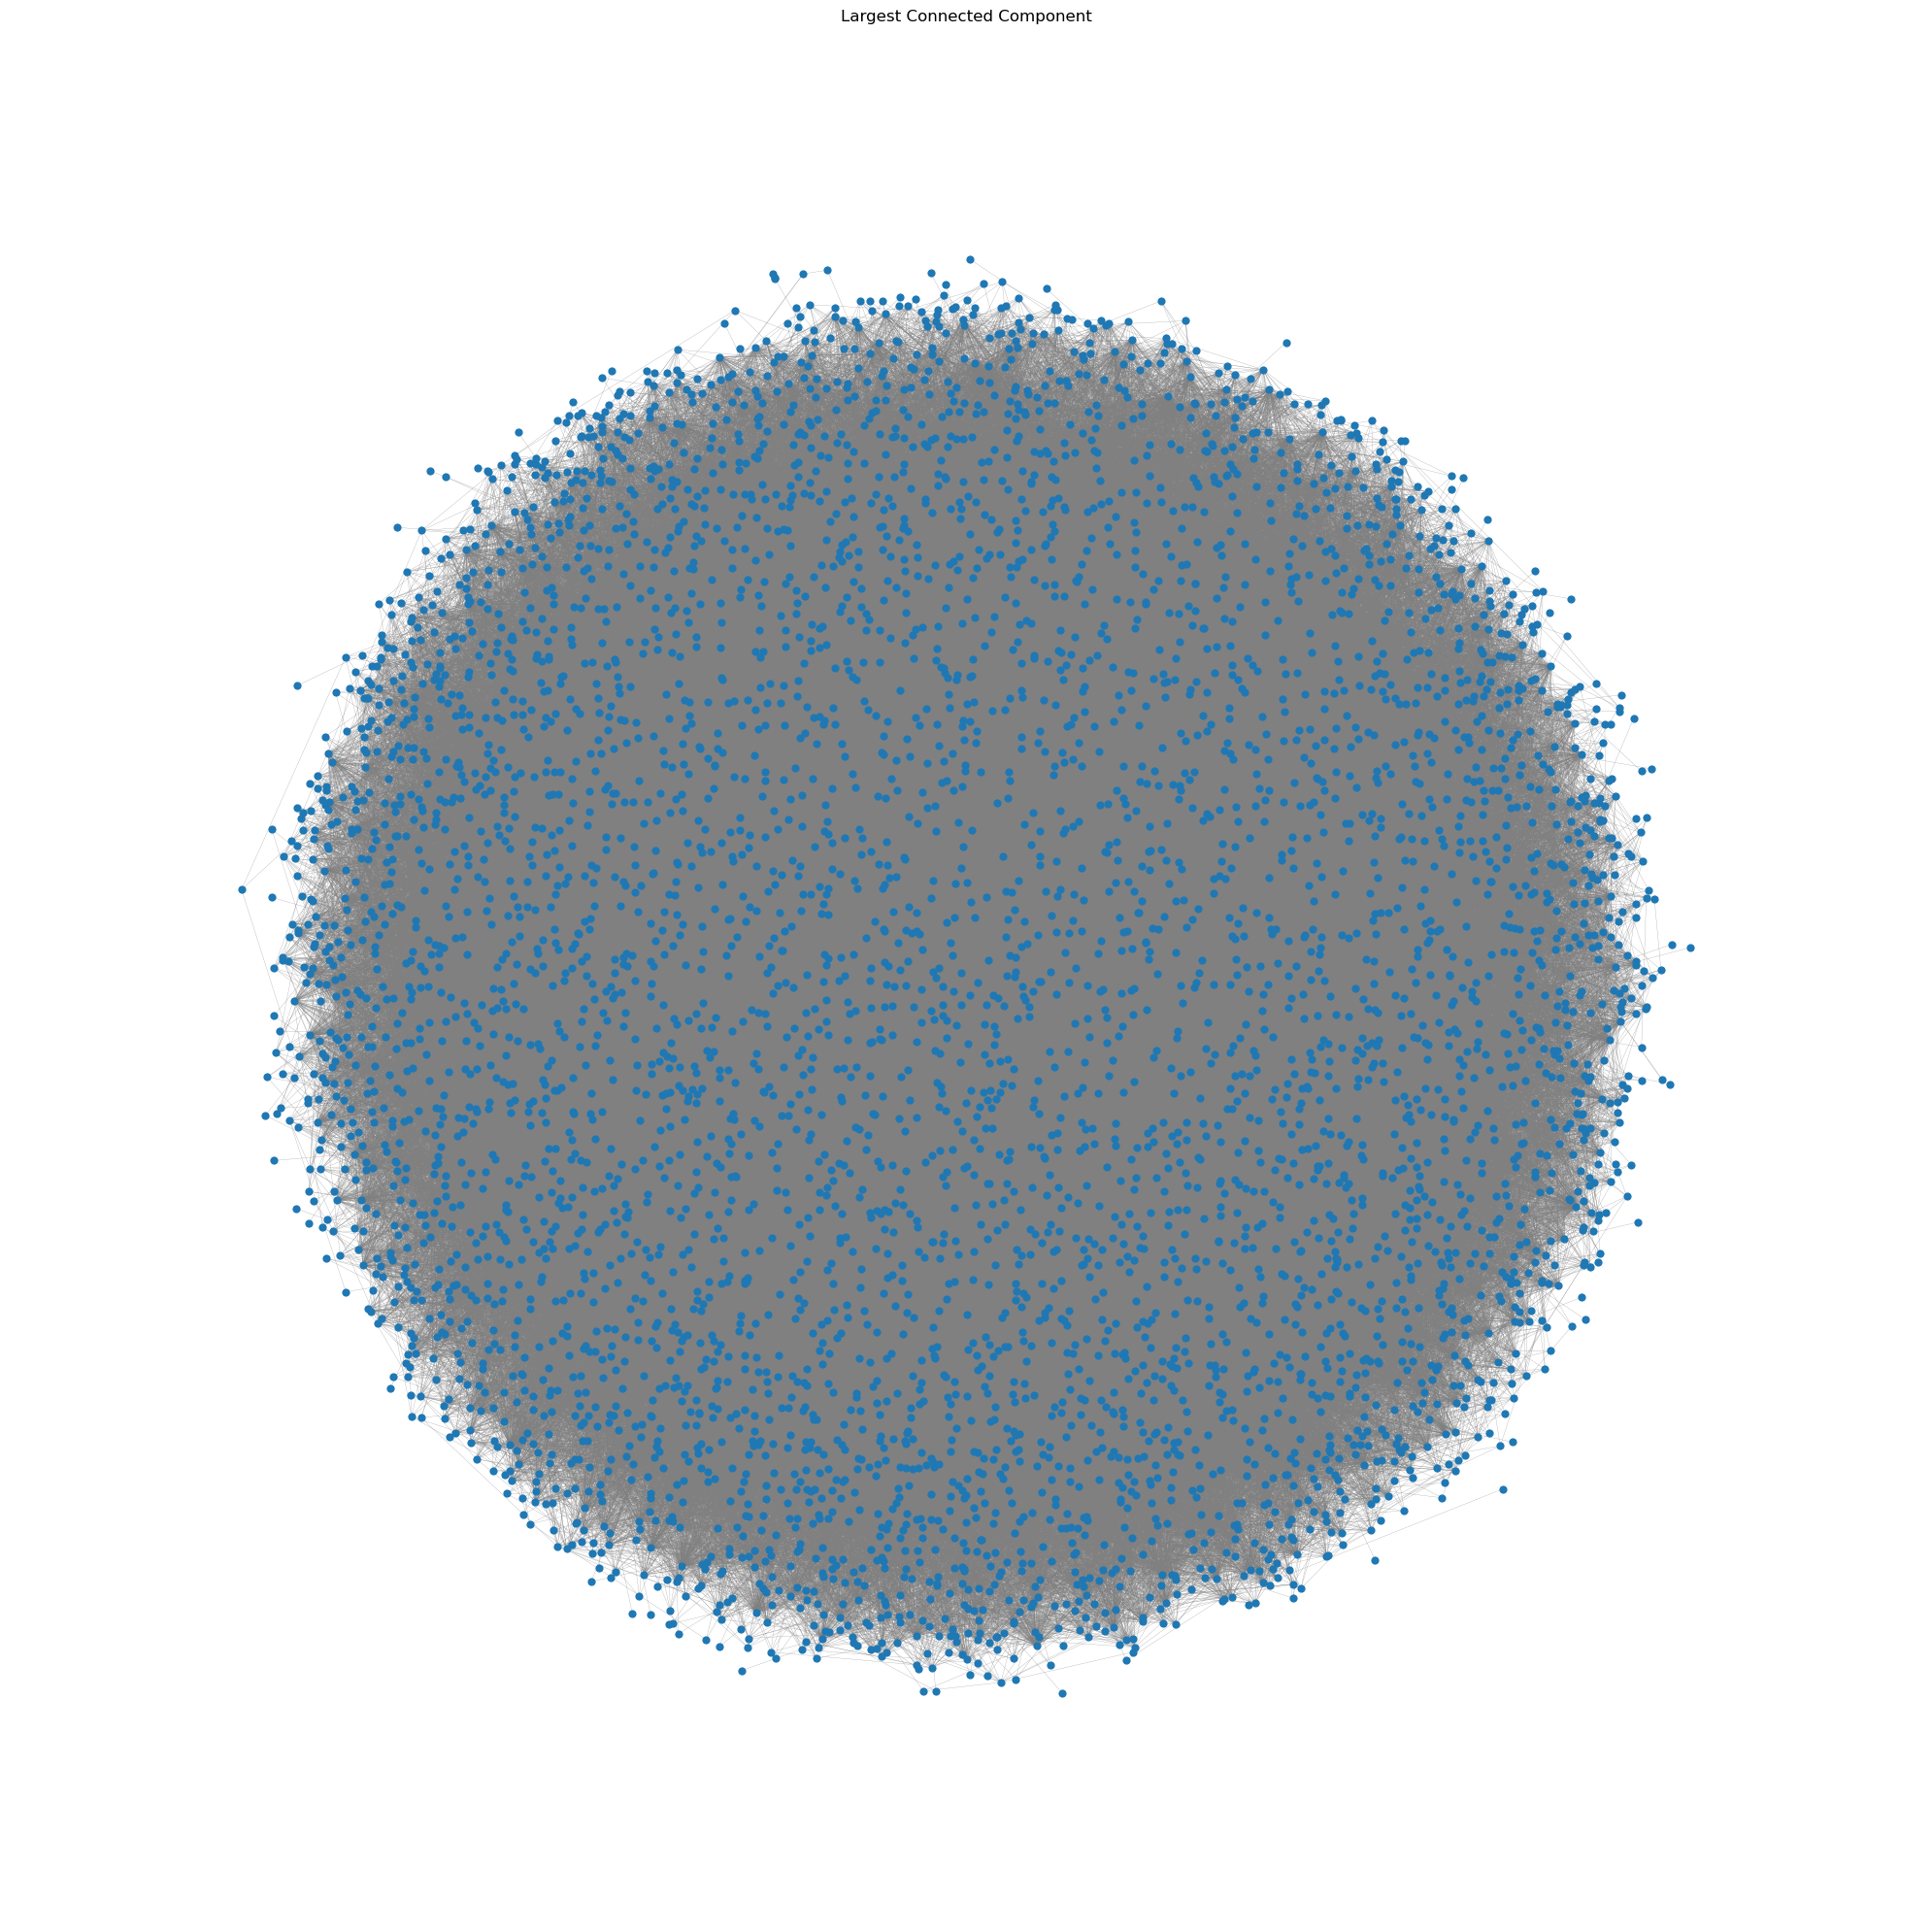

In [334]:
fig, ax = plt.subplots(1,1, figsize=(20, 20))

nx.draw_networkx_nodes(G, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('All Components')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(20, 20))

nx.draw_networkx_nodes(H, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(H, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('Largest Connected Component')

plt.tight_layout()
plt.show()

#### **Plotting Degree Distribution**

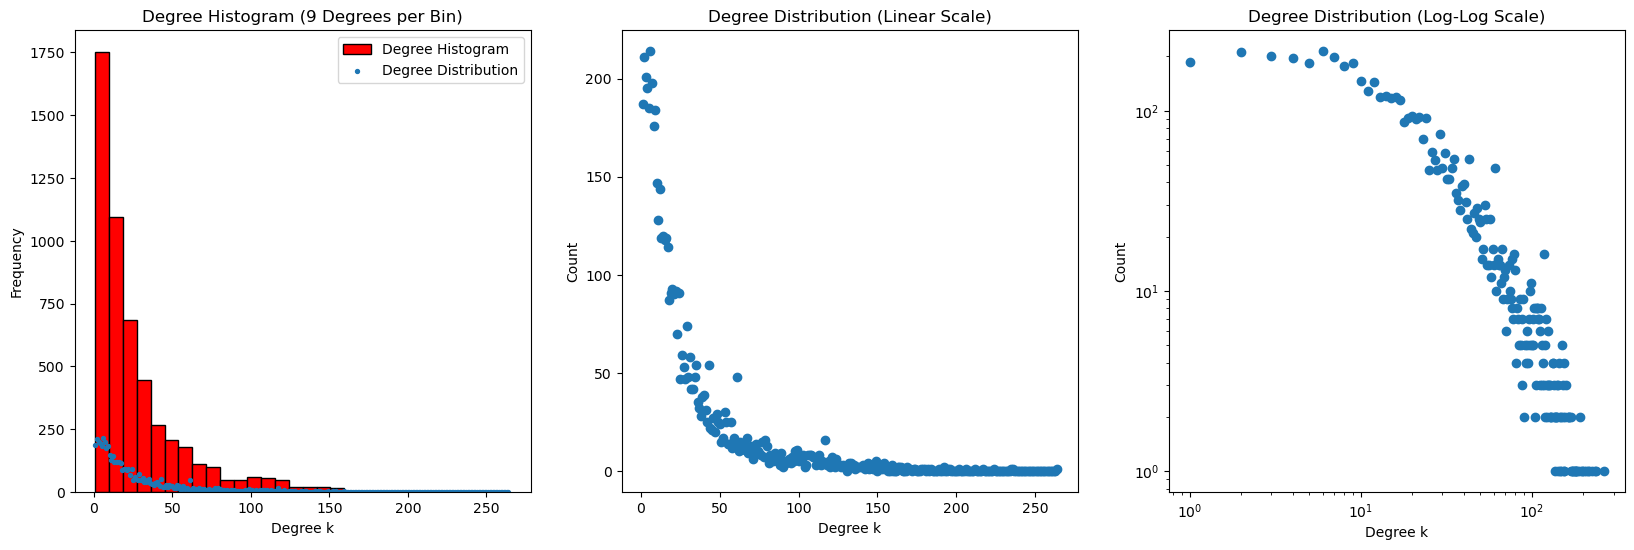

In [335]:
degrees = [H.degree(n) for n in H.nodes()]
k_max = 0
k_min = len(H.edges())
for i in H.nodes():
    if H.degree(i) > k_max:
        k_max = H.degree(i)
    if H.degree(i) < k_min:
        k_min = H.degree(i)

degree_dist = np.histogram([H.degree(i) for i in H.nodes()], bins=range(1, k_max+1))

fig, ax = plt.subplots(1,3, figsize=(20, 6))

ax[0].hist(degrees, bins=30, label='Degree Histogram', color='red', edgecolor='black')
ax[0].scatter(degree_dist[1][:-1],degree_dist[0], s=8, label='Degree Distribution')
ax[0].set_xlabel('Degree k')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Degree Histogram (9 Degrees per Bin)')
ax[0].legend()

ax[1].scatter(degree_dist[1][:-1],degree_dist[0])
ax[1].set_xlabel('Degree k')
ax[1].set_ylabel('Count')
ax[1].set_title('Degree Distribution (Linear Scale)')

ax[2].scatter(degree_dist[1][:-1],degree_dist[0])
ax[2].set_xlabel('Degree k')
ax[2].set_ylabel('Count')
ax[2].set_title('Degree Distribution (Log-Log Scale)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
plt.show()

## Creating Louvain Communities

In [337]:
louvain_communities = nx.community.louvain_communities(H, resolution=1.0, seed=42)
print("Number of communities detected by Louvain method:", len(louvain_communities))

# Printing size of each community
for idx, community in enumerate(louvain_communities):
    print(f"Community {idx+1}: {len(community)} nodes")

Number of communities detected by Louvain method: 14
Community 1: 311 nodes
Community 2: 781 nodes
Community 3: 322 nodes
Community 4: 715 nodes
Community 5: 507 nodes
Community 6: 113 nodes
Community 7: 613 nodes
Community 8: 252 nodes
Community 9: 52 nodes
Community 10: 76 nodes
Community 11: 665 nodes
Community 12: 356 nodes
Community 13: 434 nodes
Community 14: 14 nodes


#### **Attaching community as node attribute**

In [377]:
for community_id, community in enumerate(louvain_communities):
    for node in community:
        H.nodes[node]["louvain_community"] = community_id

#### **Drawing graph colored by louvain communities**

c:\Users\willi\anaconda3\envs\SGI\Lib\site-packages\networkx\drawing\layout.py:1809: RuntimeWarning:

invalid value encountered in divide

C:\Users\willi\AppData\Local\Temp\ipykernel_39860\3773395332.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



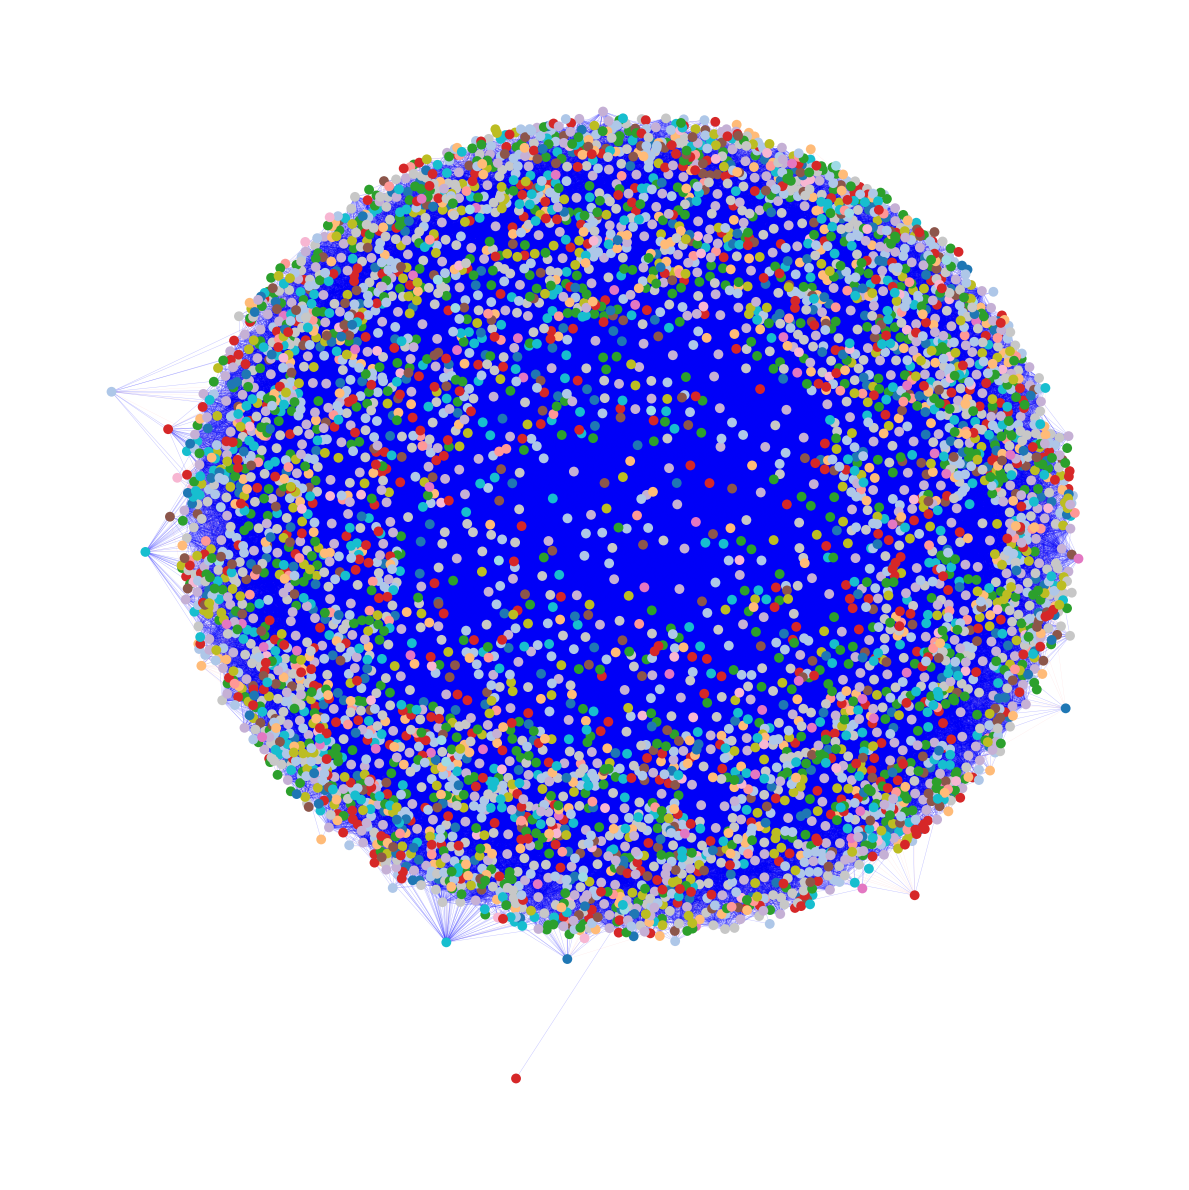

In [ ]:
assert pos is not None, "Position dictionary 'pos' is not defined. It should have been created/loaded in earlier in the code."

node_comm = nx.get_node_attributes(H, "louvain_community")
edges_intra = [(u, v) for u, v in H.edges() if node_comm.get(u) == node_comm.get(v)]
edges_inter = [(u, v) for u, v in H.edges() if node_comm.get(u) != node_comm.get(v)]

cmap = plt.cm.get_cmap('tab20', len(louvain_communities))
node_colors = [node_comm.get(n, -1) for n in H.nodes()]

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(H, pos, edgelist=edges_inter, width=0.2, alpha=0.1, edge_color="red", ax=ax)
nx.draw_networkx_edges(H, pos, edgelist=edges_intra, width=0.3, alpha=0.25, edge_color="blue", ax=ax)
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=50, cmap=cmap, linewidths=0, ax=ax)
ax.set_axis_off()
plt.tight_layout()
plt.show()

#### **Creating dataframe for singular communities**

In [371]:
comm_index = 3
assert comm_index < len(louvain_communities), "comm_index is out of range."
community_nodes = louvain_communities[comm_index]
community_subgraph = H.subgraph(community_nodes)
print("Number of nodes in selected community subgraph:", community_subgraph.number_of_nodes())
print("Percentage of total nodes in community subgraph:", round((community_subgraph.number_of_nodes() / H.number_of_nodes()) * 100, 2), "%")

assert combined_data_df is not None, "combined_data_df is not defined."

country_counts_lc = Counter([community_subgraph.nodes[article_id]["country"] for article_id in community_subgraph.nodes()])
country_counts_pd_lc = pd.DataFrame(list(country_counts_lc.items()), columns=["country", "count"])
df_lc = pd.merge(country_counts_pd_lc, combined_data_df[["country", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country", how="left")
df_lc.head()

Number of nodes in selected community subgraph: 715
Percentage of total nodes in community subgraph: 13.72 %


country  count  press freedom current rank  \
0                     india    167                       151.0   
1  united states of america    190                        57.0   
2                   namibia      8                        28.0   
3                 australia     49                        29.0   
4            united kingdom     36                        20.0   

   press freedom slope of ranks  corruption latest score  \
0                          2.32                     38.0   
1                          1.41                     65.0   
2                         -0.53                     49.0   
3                         -0.09                     77.0   
4                          0.24                     71.0   

   corruption score slope  
0                    0.23  
1                   -0.74  
2                   -0.01  
3                   -0.66  
4                   -0.47

In [372]:
assert world is not None, "world GeoDataFrame is not defined."

df_fixed_lc = df_lc.copy()
df_fixed_lc["country"] = df_fixed_lc["country"].str.strip().str.lower()

name_fix = {
    "netherland": "netherlands",
}
df_fixed_lc["country"] = df_fixed_lc["country"].replace(name_fix)
df_fixed_lc["country_norm"] = df_fixed_lc["country"]

gdf_lc = world.merge(df_fixed_lc[["country_norm", "count", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country_norm", how="inner")
gdf_lc["articles_per_million"] = round((gdf_lc["count"] / gdf_lc["POP_EST"]) * 10e6 , 2)
keep = ['country_norm', 'POP_EST', 'GDP_MD', 'INCOME_GRP', 'count', 'articles_per_million', 'geometry', "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']
gdf_lc = gdf_lc[keep]
gdf_lc.rename(columns={"country_norm": "country", "POP_EST": "population", 'GDP_MD': "gross domestic product (millions usd)", "INCOME_GRP": "income group", "count": "number of articles", "articles_per_million": "articles per million capita"}, inplace=True)

#### **Plotting interactive cloropeth map for singular louvain community**

In [373]:
gdf_lc.explore(column="articles per million capita", legend=True)